## Chap06_물류의 최적경로를 컨설팅

**상황**
* 어떤 기업의 창고에는 1만 개의 상품 재고가 보관중
* 전국 여러 공장에서 생산된 상품이 각각의 창고에 도착함


*전국으로 상품을 판매하는 기억에게 어디에서 어느 정도의 상품을 생산하고, 어느 창고에 재고를 보관하고, 어느 대리점에 몇 개의 상품을 배송하는가 하는 '물류'는 상품의 매출을 좌우하는 생명선이라고 할 수 있다.*


**6장 내용**
* '물류'의 기초가 되는 '운송최적화'를 검토
* 실제 물류 데이터로부터 네트워크 구조를 가시화
* 최적 물류 계획을 세우는 흐름
* '고객의 소리'와 '전제조건' 확인 및 데이터 불러오기

**고객의 소리**

우리 회사는 제품의 제조에서 물류까지 도맡아서 하고 있습니다. 최근 데이터 분석이라는 것을 알게 되어 상담을 받아 보려고 합니다. 최근 회사 이익이 감소하고 있어서 물류비용을 줄이고 효율화를 생각하고 있습니다. 먼저, 제품의 부품을 보관하는 창고에서 생산 공장까지 운송 비용을 낮출 수 있을지 검토하고 싶다. 

**전제 조건**

* 부품을 보관하는 창고에서 생산 공장으로 부품을 운송
* 각 창고와 공장 구간의 운송 비용은 과거 데이터에서 정량적으로 계산돼 있다.

*집계 기간 : 2019.01.01 ~ 2019.12.31*

* 북부지사와 남부지사의 데이터를 시스템에서 추출해 CSV로 제공 

### 테크닉 51 : 물류 데이터 불러오기

* tbl_factory.csv : 생산 공장 데이터 
* tbl_warehouse.csv : 창고 데이터 
* rel_cost.csv : 창고와 공장 간의 운송 비용
* tbl_transaction.csv : 운송 실적 

In [1]:
import pandas as pd 

# 공장데이터 불러오기 
factories = pd.read_csv('tbl_factory.csv', index_col = 0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부
FC00006,광주공장,30,남부
FC00007,부산공장,25,남부
FC00008,울산공장,16,남부


In [2]:
# 창고 데이터 불러오기 
# 'index_col=0'는 데이터프레임에서 첫 번째 열을 인덱스로 사용하도록 설정하는 매개변수
warehouse = pd.read_csv('tbl_warehouse.csv', index_col = 0)
warehouse

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부
WH00006,광주창고,65,남부


In [3]:
# 비용 테이블 
cost = pd.read_csv('rel_cost.csv', index_col = 0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
# 운송 실적 테이블
trans = pd.read_csv('tbl_transaction.csv', index_col = 0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


공장 데이터 'FCID'와 창고 데이터 'WHID'는 비용 데이터나 운송 실적 데이터에도 있는 것으로 보아 이것이 키인 것을 확인할 수 있음

비용 데이터는 공장(FCID)과 창고(WHID)의 조합으로 관리되고 있음 

* 'WH00001 창고'에서 'FC00001 공장'으로 상품을 운송할 경우 비용이 0.4 든다는 의미

운송 실적 테이블은 실제 운송 날짜, 출발 공장(ToFC), 도착 창고(FromWH), 운송 개수가 로그로 보관되어 있음

**데이터 분석의 기초가 될 데이터는 운송 실적이기 때문에 이것을 중심으로 각 정보를 결합(레프트 조인)합니다.**

In [5]:
join_data = pd.merge(trans, cost, left_on = ["ToFC", "FromWH"], right_on = ["FCID", "WHID"], how = "left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


결합한 데이터에 공장 데이터 추가하기 

In [7]:
join_data = pd.merge(join_data, factories, left_on = "ToFC", right_on = "FCID", how = "left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,수원공장,29,북부
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,서울공장,28,북부


* left_on = "ToFC" : 결합의 기준이 되는 열을 지정
*  right_on = "FCID" : 두 번째 데이터 프레임인 factories의 어떤 열을 사용할 것인지를 지정
* how = "left" : 왼쪽 데이터 프레임인 join_data에 있는 데이터를 기준으로 결합

**칼럼 순서 정렬**
* 창고 데이터 추가 결합 후 컬럼 정렬

In [11]:
join_data = pd.merge(join_data, warehouse, left_on = "FromWH", right_on = "WHID", how = "left")
join_data = join_data[["TransactionDate", "Quantity", "Cost", "ToFC", "FCName", "FCDemand", "FromWH", "WHName", "WHSupply", "WHRegion"]]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,WH00002,용인창고,41,북부


창고 정보를 추가한 후에 칼럼을 '운송 날짜, 운송 수량, 비용, 공장 ID, 공장명, 공장 수요, 창고ID, 창고명, 창고 공급량, 지사'로 보기 쉽게 변경 
    
*연결에 사용하고 남은 FCID 등은 데이터에서 삭제* 

In [12]:
# 북부 데이터 추출
north = join_data.loc[join_data["WHRegion"] == "북부"]
north.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,WH00002,용인창고,41,북부
7,2019-01-01 09:09:30,12,1.5,FC00001,서울공장,28,WH00003,수원창고,42,북부
8,2019-01-01 10:52:55,27,1.5,FC00003,인천공장,31,WH00003,수원창고,42,북부


In [13]:
# 남부 데이터 추출
south = join_data.loc[join_data["WHRegion"] == "남부"]
south.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부
5,2019-01-01 08:56:09,31,0.3,FC00005,대구공장,21,WH00005,대구창고,72,남부
6,2019-01-01 09:00:15,33,0.7,FC00006,광주공장,30,WH00006,광주창고,65,남부
9,2019-01-01 14:12:51,21,0.7,FC00006,광주공장,30,WH00006,광주창고,65,남부


### 테크닉 52 : 현재 운송량과 비용 확인 

1년간 운송한 부품 수와 비용 집계

In [15]:
# 지사의 비용합계 계산 
print("북부지사 총 비용 : " + str(north["Cost"].sum()) + "만원")
print("남부지사 총 비용 : " + str(south["Cost"].sum()) + "만원")

북부지사 총 비용 : 2189.3만원
남부지사 총 비용 : 2062.0만원


In [16]:
# 지사의 총운송개수
print("북부지사의 총부품 운송개수 : " + str(north["Quantity"].sum()) + "개")
print("남부지사의 총부품 운송개수 : " + str(south["Quantity"].sum()) + "개")

북부지사의 총부품 운송개수 : 49146개
남부지사의 총부품 운송개수 : 50214개


1년간의 운송 실적으로 실제로 운송한 부품의 수 집계(단위 : 개)

**북부지사보다 남부지사 쪽이 부품을 더 많이 운송하고 있음 확인**

In [17]:
# 부품 1개당 운송비용
tmp = (north["Cost"].sum() / north["Quantity"].sum()) * 10000
print("북부지사의 부품 1개당 운송 비용 : " + str(int(tmp)) + "원")
tmp = (south["Cost"].sum() / south["Quantity"].sum()) * 10000
print("남부지사의 부품 1개당 운송 비용 : " + str(int(tmp)) + "원")

북부지사의 부품 1개당 운송 비용 : 445원
남부지사의 부품 1개당 운송 비용 : 410원


**남부지사쪽이 1개당 운송 비용이 낮음 확인**

운송비용은 '창고 → 공장' 간에 발생하기 때문에 단순히 운송 비용 절감을 하는 것만으로도 전체 물류 비용 억제 가능 

* 각 지사의 평균 운송 비용 계산

In [21]:
# 비용을 지사별로 집계 
cost_chk = pd.merge(cost, factories, on = "FCID", how = "left")
#평균
print("북부지사의 평균 운송 비용 : " + str(cost_chk["Cost"].loc[cost_chk["FCRegion"] == "북부"].mean()) + "원")
print("남부지사의 평균 운송 비용 : " + str(cost_chk["Cost"].loc[cost_chk["FCRegion"] == "남부"].mean()) + "원")

북부지사의 평균 운송 비용 : 1.075원
남부지사의 평균 운송 비용 : 1.05원


각 지사의 평균 운송 비용은 거의 같으므로 북부지사보다 남부지사 쪽이 '효율 높게' 부품을 운송하고 있다는 것을 확인 

### 테크닉 53 : 네트워크를 가시화 

최적 경로를 가시화하는 방법인 네트워크 가시화 

* 네트워크 가시화에 유용한 라이브러리 : NetworkX

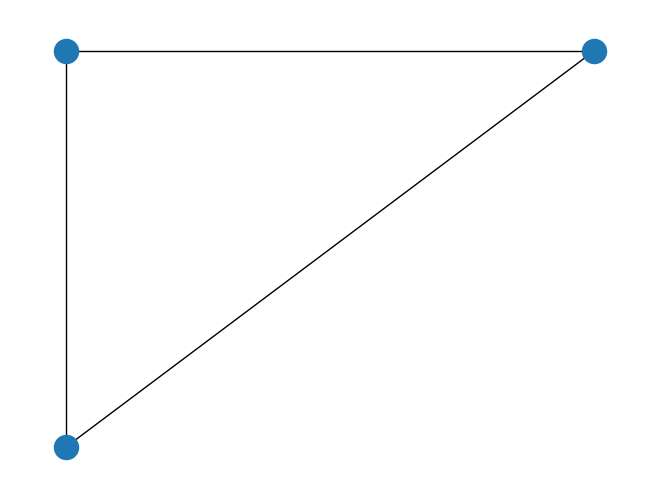

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 객체 생성 
G = nx.Graph()

#노드 설정 
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

# 엣지 설정 
G.add_edge("nodeA", "nodeB")
G.add_edge("nodeB", "nodeC")
G.add_edge("nodeC", "nodeA")

# 좌표 설정 
pos = {}
pos["nodeA"] = (0, 0)
pos["nodeB"] = (1, 1)
pos["nodeC"] = (0, 1)

# 그리기
nx.draw(G, pos)

# 표시 
plt.show()



① 그래프 객체 선언

② 노드(nodeA, nodeB, nodeC)와 각각을 연결할 엣지 설정 

③ 노드의 좌표 설정 

④ 함수 draw 이용해서 그리기 

**네트워크를 가시화해서 창고에서 대리점까지의 물류를 표현 가능**

    → 숫자만으로 알기 어려운 물류의 쏠림과 같은 전체 그림 파악 가능

### 테크닉 54 : 네트워크에 노드 추가 

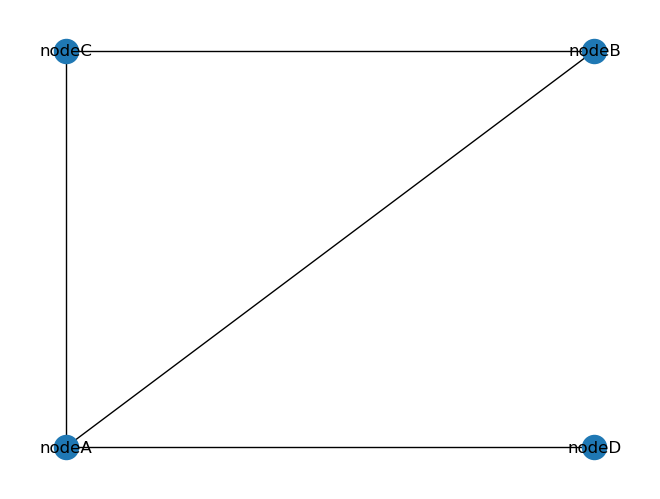

In [24]:
G.add_node("nodeD")
G.add_edge("nodeA", "nodeD")
pos["nodeD"] = (1, 0)
nx.draw(G, pos, with_labels = True) # 노드에 붗은 이름(라벨) 표시

### 테크닉 55 : 경로에 가중치 부여

가중치를 이용해서 노드 사이의 엣지 굵기를 바꾸면 물류의 최적 경로를 알기 쉽게 가시화 가능 

(A, B) = 1.43353
(A, C) = 9.44669
(A, D) = 5.21848
(A, E) = 0.0
(B, C) = 4.5615
(B, D) = 5.68434
(B, E) = 0.0
(C, D) = 9.43748
(C, E) = 0.0
(D, E) = 6.66767


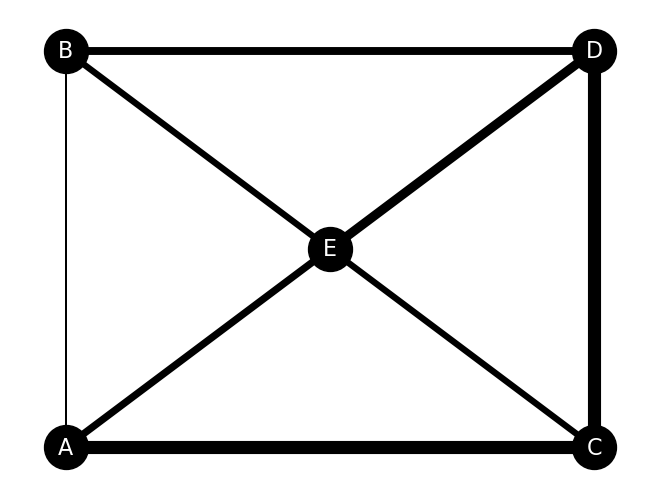

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

# 그래프 객체 생성
G = nx.Graph()

# 'df_w'의 열 이름을 노드로 추가하여 그래프에 노드를 설정
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 엣지 설정 & 가중치 리스트화
size = 10 # 엣지 가중치에 사용할 크기를 설정
edge_weights = [] # 엣지 가중치를 저장할 빈 리스트 
num_pre = 0 # 이전 엣지 수를 저장하는 변수를 초기화
# 엣지 가중치 확인용 번역자 추가 코드
name = ['A','B','C','D','E'] 

for i in range(len(df_w.columns)): #  첫 번째 루프는 노드 i
    for j in range(len(df_w.columns)): # 두 번째 루프는 노드 j
        if not (i==j): # 두 번째 루프는 노드 j
            # 그래프 G에 i와 j 사이의 엣지를 추가
            G.add_edge(df_w.columns[i],df_w.columns[j])
            # 새로운 엣지가 추가되었는지 확인
            if num_pre<len(G.edges):
                # 현재 엣지 수를 저장
                num_pre = len(G.edges)
                # 엣지 가중치 추가
                edge_weights.append(df_w.iloc[i][j]*size)
               
                # 엣지 가중치 확인용 번역자 추가 코드
                print(f'({name[i]}, {name[j]}) = {np.round(edge_weights[-1],5)}')
               

# 좌표 설정 : 좌표를 저장할 빈 딕셔너리
pos = {}
# 노드의 좌표를 설정
for i in range(len(df_w.columns)):
    # 현재 노드의 이름
    node = df_w.columns[i]
    # 노드의 좌표를 pos 딕셔너리에 저장
    pos[node] = (df_p[node][0],df_p[node][1])

# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

### 테크닉 56 : 운송 경로 정보 불러오기

In [30]:
import pandas as pd 
# 데이터 불러오기 
df_tr = pd.read_csv('trans_route.csv', index_col = "공장")
df_tr.head()

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### 테크닉 57 : 운송 경로 정보로 네트워크 가시화 

* trans_route.csv : 창고 W1, W2, W3에서 공장 F1, F2, F3, F4로 운송량 기록한 운송 경로
* trans_route_pos.csv : 창고(W) 및 공장(F)의 위치 정보

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv('trans_route.csv', index_col = "공장")
df_pos = pd.read_csv('trans_route_pos.csv')
display(df_tr, df_pos)

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


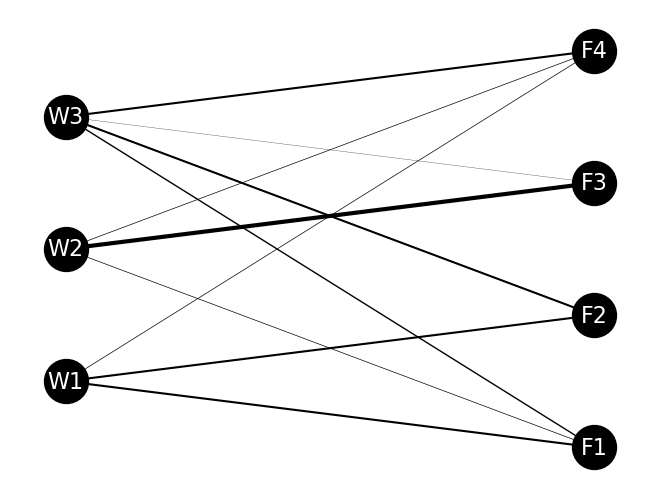

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv('trans_route.csv', index_col = "공장")
df_pos = pd.read_csv('trans_route_pos.csv')

# 그래프 객체 생성
G = nx.Graph()

# 노드 설정 
for i in range(len(df_pos.columns)) :
    G.add_node(df_pos.columns[i])
    
# 엣지 설정 및 가중치 리스트화 
num_pre = 0
edge_weights = []
size = 0.1

for i in range(len(df_pos.columns)) :
    for j in range(len(df_pos.columns)) :
        if not (i == j ):
            # 엣지 추가 
            G.add_edge(df_pos.columns[i], df_pos.columns[j]) 
            # 엣지 가중치 추가 
            if num_pre < len(G.edges) : 
                num_pre = len(G.edges) 
                weight = 0 
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index) :
                    # 만약 df_tr 데이터프레임에서 i에서 j로 향하는 엣지의 데이터가 존재한다면, 
                    # 이 데이터를 가져와서 weight에 할당
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]] :
                        # df_tr 데이터프레임에서 i에서 j로 가는 엣지의 가중치
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size 
                        
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index) :
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]] :
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size 
                # weight 변수에 할당된 엣지 가중치를 edge_weights 리스트에 추가
                edge_weights.append(weight)
                
# 좌표 설정 
pos = {}
for i in range(len(df_pos.columns)) :
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])
    

# 그리기  (with_labels = True : 노드에 레이블 (이름)을 표시)
nx.draw(G, pos, with_labels = True, font_size = 16, node_size = 1000, node_color = 'k', font_color = 'w', 
       width = edge_weights)

               
               
# 표시 
plt.show()

### 테크닉 58 : 운송 비용 함수 작성

* '최적화 문제' 푸는 패턴 

① 최소화(or 최대화)하고 싶은 것을 목적 함수로 정의 → **목적 함수 정의**

② 다음으로 최소화(or 최대화)를 합에 있어 지켜야 할 조건 정의 → **제약 조건 정의**

**생각할 수 있는 여러가지 운송 경로의 조합 중에서 제약 조건을 만족시키면서 목적함수를 최소화(or 최대화)하는 조합을 선택하는 것이 최적화 문제의 큰 흐름**

* 가설 : 운송 비용을 낮출 효율적인 운송 경로가 존재한다.

*가설을 입증하고 운송 경로를 최적화하기 위해 운송비용을 계산할 함수를 작성하고 그것을 목적함수로 정의*

In [48]:
import pandas as pd

# 데이터 불러오기 
df_tr = pd.read_csv('trans_route.csv', index_col = "공장")
df_tc = pd.read_csv('trans_cost.csv', index_col = "공장")
display(df_tc, df_tc)

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


**운송 비용 계산**

     - (운송 경로의 운송량 * 비용) 을 전부 더해서 계산 

In [64]:
# 운송 비용 함수 
def trans_cost(df_tr, df_tc) :
    cost = 0 
    for i in range(len(df_tc.index)) : # i : W(창고)
        for j in range(len(df_tr.columns)) : # j : F(공장)
            cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
    
    return cost

print("총 운송 비용 :" + str(trans_cost(df_tr, df_tc)) + "만 원")

총 운송 비용 :1493만 원


### 테크닉 59 : 제약 조건 

운송 비용 함수를 최적화하기 위해 필요한 제약 조건 

각 창고는 공급 가능한 부품 수에 제한이 있고, 각 공장은 채워야 할 최소한의 제품 제조량이 있다. 


In [55]:
# 데이터 불러오기 
df_tr = pd.read_csv('trans_route.csv', index_col = "공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')
display(df_tr, df_demand, df_supply)

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [61]:
# 수요측 제약 조건
for i in range(len(df_demand.columns)) :
    temp_sum = sum(df_tr[df_demand.columns[i]]) 
    print(str(df_demand.columns[i]) + "으로 운송량 :" + str(temp_sum) + "(수요량 :"+str(df_demand.iloc[0][i]) + ")")
    if temp_sum >= df_demand.iloc[0][i] : 
        print("수요량을 만족시키고 있음")
    else :
        print("수요량을 만족시키지 못하고 있음. 운송경로 재계산 필요")
        
# 공급측 제약 조건 
for i in range(len(df_supply.columns)) :
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i]) + "부터의 운송량 :" + str(temp_sum) + " (공급한계 :" + str(df_supply.iloc[0][i]) + ")")
    
    if temp_sum <= df_supply.iloc[0][i] :
        print("공급한계 범위 내")
    else : 
        print("공급한계 초과. 운송경로 재계산 필요")

F1으로 운송량 :30(수요량 :28)
수요량을 만족시키고 있음
F2으로 운송량 :30(수요량 :29)
수요량을 만족시키고 있음
F3으로 운송량 :32(수요량 :31)
수요량을 만족시키고 있음
F4으로 운송량 :25(수요량 :25)
수요량을 만족시키고 있음
W1부터의 운송량 :35 (공급한계 :35)
공급한계 범위 내
W2부터의 운송량 :40 (공급한계 :41)
공급한계 범위 내
W3부터의 운송량 :42 (공급한계 :42)
공급한계 범위 내


* 각 공장으로 운반되는 부품의 수와 각 공장에 대한 수요량을 비교하면 공장에서 제조된 제품의 수가 수요량을 만족시키는지 여부를 검토할 수 있음 → 제약 조건 

* 각 창고에서 출하되는 부품의 수와 각 창고의 공급 한계량을 비교하면 창고에서 공장으로 출하되는 부품의 수가 창고의 공급 한계를 넘는지를 검토할 수 있음 →  If 문으로 확인해 현재 운송 경로가 제약 조건을 만족시키는지 알 수 있음 

**이 제약 조건을 만들어두면 운송 경로를 변경했을 때 새로운 경로가 제약 조건을 만족하는지를 확인할 수 있음**


### 테크닉 60 : 운송 경로를 변경해서 운송 비용 함수의 변화 확인

제약조건은 테크닉 59에서 작성한 if 문에 의한 판단 결과를 그래프화하면 각 제약 조건을 만족시키는지 확인 가능 

 *(조건을 만족하는 경우 1, 그렇지 않으면 0을 표시)*

W1에서 F4로의 운송을 줄이고, 그만큼을 W2에서 F4로의 운송으로 보충하는 것 

In [63]:
import pandas as pd
import numpy as np

# 데이터 불러오기 
df_tr_new = pd.read_csv('trans_route_new.csv', index_col = "공장")
print(df_tr_new)


# 총 운송 비용 재꼐산 
print("총 운송 비용(변경 후) :" + str(trans_cost(df_tr_new, df_tc)) + "만 원")

# 제약 조건 계산 함수
# 수요측 

def condition_demand(df_tr, df_demand) : 
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)) :
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]) :
            flag[i] = 1
    
    return flag

# 공급측 
def condition_supply(df_tr, df_supply) :
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)) :
        temp_sum = sum(df_tr.loc[df_supply.columns[i]]) 
        if temp_sum <= df_supply.iloc[0][i] :
            flag[i] = 1
            
    return flag 

print("수요조건 계산결과 :" + str(condition_demand(df_tr_new, df_demand)))
print("공급조건 계산결과 :" + str(condition_supply(df_tr_new, df_supply)))

    F1  F2  F3  F4
공장                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
총 운송 비용(변경 후) :1428만 원
수요조건 계산결과 :[1. 1. 1. 1.]
공급조건 계산결과 :[1. 0. 1.]


원래 운송비용 : 1493만 원 -> 1428만 원으로 약간의 비용 절감 확인 

두 번째 공급 조건을 만족시키지 못 해 공장 W2의 공급 한계를 넘어버린 것을 알 수 있음 